In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [171]:
layer_names = ['dense', 'batch_norm', 'dense', 'softmax']
hidden_units = [16,8,8,10]
input_size = 784
hidden_units.insert(0, input_size)

learning_rate = 0.01
keep_prob = 0.9

In [3]:
class Dense:
    def __init__(self, units, input_size, activation, name):
        self.W = tf.Variable(tf.random.normal([units, input_size]) * tf.math.sqrt(1/input_size), name=(name + '_W'))
        self.b = tf.Variable(tf.zeros([units,1]), name=(name + '_b'))
        self.activation = activation

    def forward(self, X, training):
        Z = tf.linalg.matmul(self.W,X) + self.b
        A = self.activation(Z)
        return A

    def get_vars(self):
        return [self.W, self.b]

In [4]:
class Batch_norm:
    def __init__(self, units, input_size, activation, name):
        self.W = tf.Variable(tf.random.normal([units, input_size]) * tf.math.sqrt(1/input_size), name=(name + '_W')) 
        self.activation = activation

        self.gamma = tf.Variable(tf.ones([units, 1]), name=(name + '_gamma'))
        self.beta = tf.Variable(tf.ones([units, 1]), name=(name + '_beta'))
        self.mu_test = tf.Variable(tf.zeros([units,1]))
        self.sigma_test = tf.Variable(tf.ones([units,1]))

    def forward(self, X, training):
        e = 10**-8

        Z = tf.linalg.matmul(self.W,X)

        if training:
            mu = tf.math.reduce_mean(Z, axis=1, keepdims=True)
            sigma = tf.math.reduce_variance(Z - mu, axis=1, keepdims=True)
            sigma = tf.math.sqrt(sigma + e)

            self.mu_test.assign(0.95*self.mu_test + 0.05*mu)
            self.sigma_test.assign(0.95*self.sigma_test + 0.05*sigma)
        else:
            mu = self.mu_test
            sigma = self.sigma_test

        Z = (Z - mu) / sigma
        Z = self.gamma * Z + self.beta

        A = self.activation(Z)
        return A

    def get_vars(self):
        return [self.W, self.gamma, self.beta]

In [5]:
class Dropout:
    def __init__(self, keep_prob):
        self.keep_prob = keep_prob

    def forward(self, X, training):
        if not training:
            return X
        X = tf.nn.dropout(X, 1-self.keep_prob)
        # D = tf.random.uniform(tf.shape(X)) < self.keep_prob
        # D = tf.cast(D, dtype=tf.float32)
        # X = X * D
        # X = X / self.keep_prob
        return X

    def get_vars(self):
        return None

In [52]:
class Softmax:
    def __init__(self, classes, input_size, name):
        self.classes = classes

        self.W = tf.Variable(tf.random.normal([classes, input_size]) * tf.math.sqrt(1/input_size), name=(name + '_W'))
        self.b = tf.Variable(tf.zeros([classes,1]), name=(name + '_b'))

    def forward(self, X, training):
        Z = tf.linalg.matmul(self.W,X) + self.b

        T = tf.math.exp(Z)
        A = T / tf.math.reduce_sum(T, axis=0)
        return A

    def get_vars(self):
        return [self.W, self.b]

In [7]:
x = tf.ones([2,20])
x = tf.math.exp(x)
print(tf.math.reduce_sum(x,axis=0).shape)

(20,)


In [96]:
def Loss(A, Y):
    loss = tf.math.log(A)
    loss = Y * loss
    loss = -tf.math.reduce_sum(loss, axis=0)
    return loss

In [84]:
def Cost(A, Y):
    losses = Loss(A, Y)
    cost = tf.reduce_mean(losses)
    return cost
    # cce = tf.keras.losses.CategoricalCrossentropy()
    # cost = cce(Y,A)
    #return cost

In [10]:
def forward_pass(X, layers, training):
    for layer in layers:
        X = layer.forward(X, training)
    return X

In [11]:
def get_vars(layers):
    var = []
    for layer in layers:
        x = layer.get_vars()
        if x != None:
            var += x
    return var

In [12]:
@tf.function
def training_step(X, Y, layers, learning_rate):
    with tf.GradientTape() as tape:
        var = get_vars(layers)
        tape.watch(var)
        A = forward_pass(X, layers, training=True)
        cost = Cost(A, Y)
    grads = tape.gradient(cost, var)
    for i in range(len(grads)):
        grad = -(grads[i] * learning_rate)
        var[i].assign_add(grad)
        pass
    return cost

In [13]:
def create_layers():
    layers = []
    i = 1
    for layer_name in layer_names:
        if layer_name == 'dense':
            layer = Dense(hidden_units[i], hidden_units[i-1], tf.nn.sigmoid, 'Dense' + str(i+1))
            layers.append(layer)
            i += 1

        elif layer_name == 'batch_norm':
            layer = Batch_norm(hidden_units[i], hidden_units[i-1], tf.nn.sigmoid, 'Batch_norm' + str(i+1))
            layers.append(layer)
            i += 1

        elif layer_name == 'dropout':
            layer = Dropout(keep_prob)
            layers.append(layer)

        elif layer_name == 'softmax':  
            layer = Softmax(hidden_units[i], hidden_units[i-1], 'Dense' + str(i+1))
            layers.append(layer)
            i += 1

    return layers

In [121]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255
y_train = tf.one_hot(y_train, depth=10, axis=0)
y_test = tf.one_hot(y_test, depth=10, axis=0)
x_train = x_train[:10000]
y_train = y_train[:,:10000]

x_train = tf.reshape(x_train, [784, -1])
x_train = tf.cast(x_train, tf.float32)

In [104]:
x_train = tf.constant([[0,0,1,1],[0,1,0,1]], dtype=tf.float32)
y_train = tf.constant([[0,1,1,0],[1,0,0,1]], dtype=tf.float32)

In [122]:
layers = create_layers()
costs = []

Epoch 1: 0.6198226809501648
Epoch 1001: 0.6152179837226868
Epoch 2001: 0.6107535362243652
Epoch 3001: 0.6061620116233826
Epoch 4001: 0.6015866994857788
Epoch 5001: 0.597261905670166
Epoch 6001: 0.5931802988052368
Epoch 7001: 0.5892448425292969
Epoch 8001: 0.5853235721588135
Epoch 9001: 0.5813757181167603


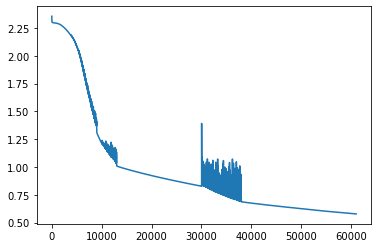

In [177]:
for i in range(10000):
    cost = training_step(x_train, y_train, layers, learning_rate)
    costs.append(cost)
    if i%1000 == 0:
        print('Epoch {0}: {1}'.format(i+1, cost))

plt.plot(costs)
plt.show()

In [179]:
prediction = forward_pass(x_train, layers, False)
a = tf.argmax(prediction, axis=0)
y = tf.argmax(y_train, axis=0)

b = a==y
b = tf.cast(b, tf.float32)
b = tf.reduce_sum(b)
print(b/10000)

tf.Tensor(0.8474, shape=(), dtype=float32)
